This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be ajusted.

In [6]:
# Imports
import numpy as np
import math
import time

# For image and video manipulation
from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
%matplotlib inline

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (tuple), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [7]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (lens_x, lens_y) = lens_sz
    (length, height) = img.size
    
    lens_corner_x=length/2.0 - lens_x/2.0 +x
    lens_corner_y=height/2.0 - lens_y/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_x, lens_corner_y+lens_y))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_x>length or lens_corner_y+lens_y>height):
        print("I came off the page!")
        return False
    return ret_img

Function to store the generated snapshot data in a file

In [8]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1
# store_snapshots(image_list)

In [12]:
 def generate_homology(img, lens, degree_num, translation_num, c):
        
    # adjustable variables
    (lens_sz_x,lens_sz_y)=lens
    image_list = []

    # this range depends on image size and lens size such that the lens doesn't come off the page
    lens_range_x = ((min(img.size)/math.sqrt(2))-lens_sz_x)/2.0
    lens_range_y = ((min(img.size)/math.sqrt(2))-lens_sz_y)/2.0

    # # no random sampling
    # degrees = np.linspace(0, 360, degree_num)
    # intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    # intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)

    # random sampling
    intervals_x = (lens_range_x*2 * np.random.random(translation_num) - lens_range_x)
    intervals_y = (lens_range_y*2 * np.random.random(translation_num) - lens_range_y)
    degrees = (360 * np.random.random(degree_num))
    degrees[0]=0
    
    # for each isometry, look at three different levels of blur

    # take snapshot images with no blur
    for d in degrees:
        rot = img.rotate(d)
        for x in intervals_x:
            for y in intervals_y:
                image_list.append(translation_snapshot(rot, (lens_sz_x,lens_sz_y), (x,y)))
                
    # add image with blurred twice
    for i in range(2):
        img = img.filter(ImageFilter.BLUR)
    for d in degrees:
        rot = img.rotate(d)
        for x in intervals_x:
            for y in intervals_y:
                image_list.append(translation_snapshot(rot, (lens_sz_x,lens_sz_y), (x,y)))

    # add image with blurred six total times
    for i in range(4):
        img = img.filter(ImageFilter.BLUR)
    for d in degrees:
        rot = img.rotate(d)
        for x in intervals_x:
            for y in intervals_y:
                image_list.append(translation_snapshot(rot, (lens_sz_x,lens_sz_y), (x,y)))
               
    # Turn images into array of data
    data = []
    x=0
    for i in image_list:
        img_arr = np.asarray(i)
        data.append(img_arr.reshape(-1))
    data = np.array(data)
    
    store_snapshots(image_list)
    
    # make persistent homology plot with ripser
    res = ripser(data, maxdim=1,  coeff =c)
    dgms = res['dgms']
    plt.figure(figsize = (4,4)) 
    plot_diagrams(dgms)

    # see how many points are persisting
    H1 = res['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    print(d[:7])
    

In [13]:
# Grab image from files
img_names = glob.glob('images/*C4pinwheel.png')
img = Image.open(img_names[0])
img.show()

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[3396.626708984375, 2724.470703125, 2321.526611328125, 1958.496337890625, 1938.28369140625, 1808.748779296875, 1585.63916015625]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[3261.4482421875, 2077.005859375, 1830.825439453125, 1805.837646484375, 1579.6337890625, 1553.053466796875, 1549.236083984375]


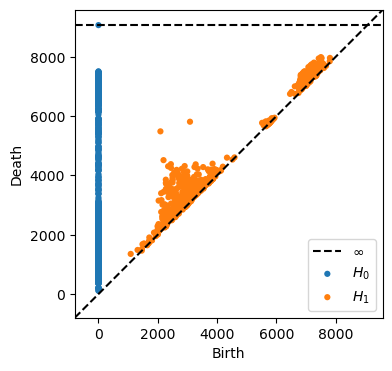

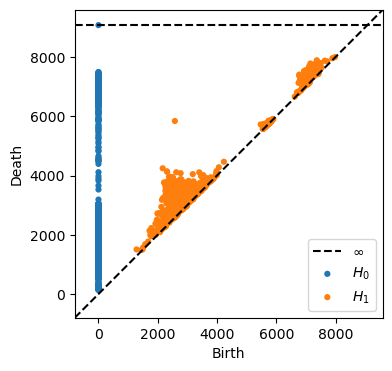

In [14]:
generate_homology(img, (60,60), 50, 4, 2)
generate_homology(img, (60,60), 50, 4, 3)

Try it with the C1 arrows

In [15]:
img_names = glob.glob('images/*C1arrows.png')
img = Image.open(img_names[0])
img.show()

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1248.6470947265625, 1120.0223388671875, 1004.7493896484375, 863.7333984375, 857.8017578125, 818.2386474609375, 783.1529541015625]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1162.796142578125, 1063.313232421875, 1038.41943359375, 899.6123046875, 892.318359375, 879.1392822265625, 837.8531494140625]


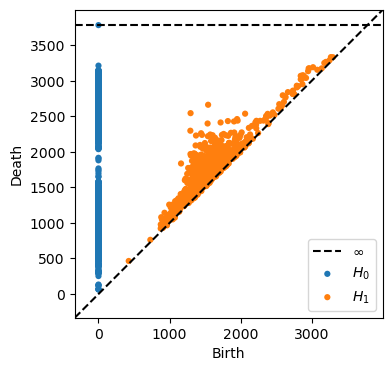

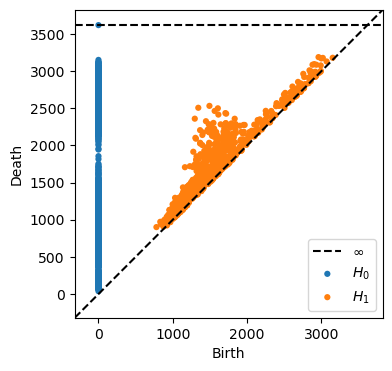

In [16]:
generate_homology(img, (70,70), 50, 4, 2)
generate_homology(img, (70,70), 50, 4, 3)

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1300.2657470703125, 1187.7083740234375, 1137.2926025390625, 1121.25634765625, 1039.5916748046875, 1016.3826904296875, 1007.4697265625]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1070.2498779296875, 1010.52099609375, 1008.5943603515625, 976.4757080078125, 943.8634033203125, 906.70458984375, 886.9310302734375]


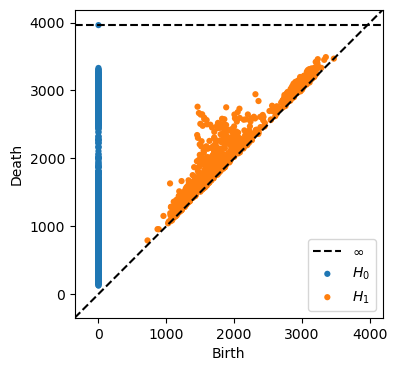

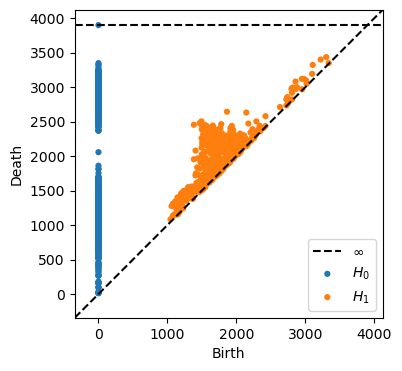

In [17]:
generate_homology(img, (76,76), 50, 4, 2)
generate_homology(img, (76,76), 50, 4, 3)

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1179.2269287109375, 1055.096435546875, 1004.0689697265625, 924.04833984375, 874.4056396484375, 873.8150634765625, 870.90185546875]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1287.2529296875, 1134.1602783203125, 1092.32666015625, 994.324951171875, 982.92333984375, 973.995361328125, 919.4947509765625]


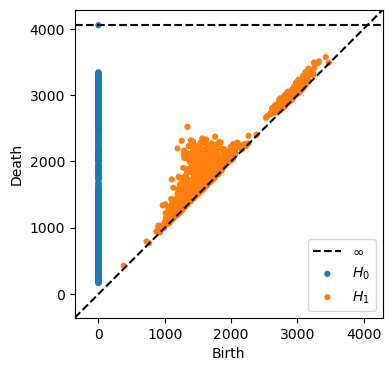

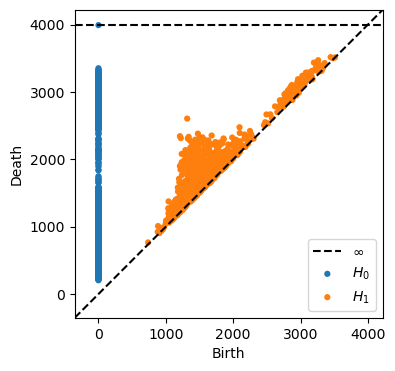

In [18]:
generate_homology(img, (76,76), 55, 5, 2)
generate_homology(img, (76,76), 55, 5, 3)

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1290.033203125, 1055.806640625, 1053.2171630859375, 915.09375, 854.5469970703125, 845.6083984375, 836.7451171875]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[1291.4244384765625, 934.481689453125, 922.155029296875, 915.458251953125, 857.5931396484375, 829.7764892578125, 821.771240234375]


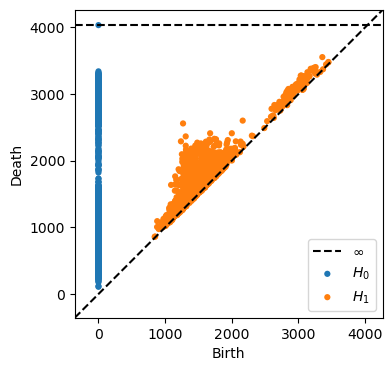

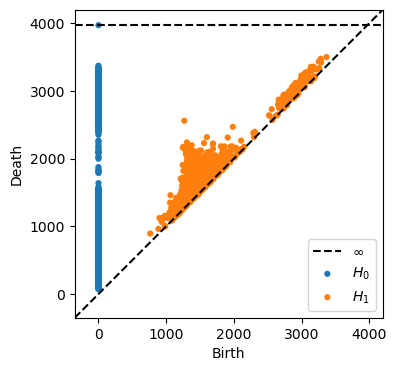

In [19]:
generate_homology(img, (76,76), 60, 5, 2)
generate_homology(img, (76,76), 60, 5, 3)

Try an arrow image with natural gradient in it

In [20]:
img_names = glob.glob('images/*C1gradientArrows.png')
img = Image.open(img_names[0])
img.show()

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[2673.912109375, 2421.404296875, 2244.467529296875, 2204.953125, 2095.02587890625, 2038.42138671875, 1967.3115234375]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[2918.729248046875, 2743.066162109375, 2514.349853515625, 2485.154296875, 2194.193359375, 2101.98681640625, 2091.23974609375]


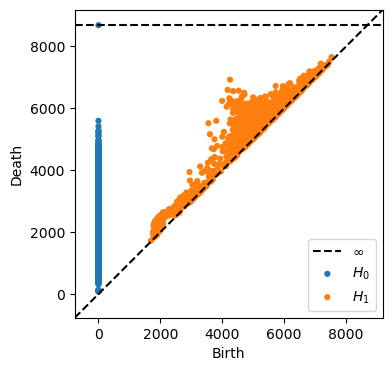

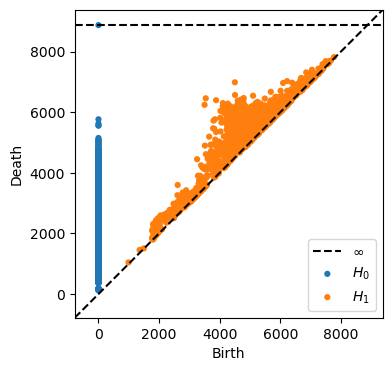

In [21]:
generate_homology(img, (76,76), 60, 5, 2)
generate_homology(img, (76,76), 60, 5, 3)

In [22]:
img.show()

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[3941.01904296875, 3843.2080078125, 3381.13720703125, 3307.95166015625, 3046.85693359375, 2846.7802734375, 2715.82470703125]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[4659.5625, 4410.86572265625, 3651.71435546875, 3455.85595703125, 3325.37109375, 3040.14404296875, 2920.7021484375]


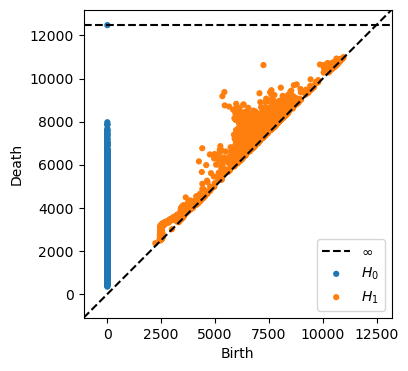

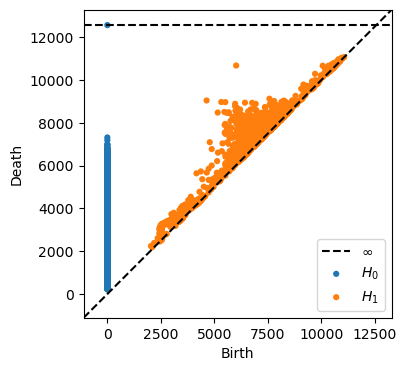

In [23]:
generate_homology(img, (100,100), 60, 5, 2)
generate_homology(img, (100,100), 60, 5, 3)

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[3863.40283203125, 3841.53173828125, 3841.154296875, 3804.125, 3721.3857421875, 3300.0625, 3161.72705078125]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[4884.09130859375, 4095.04052734375, 3736.10595703125, 3447.3466796875, 3273.220703125, 3270.76513671875, 3258.158203125]


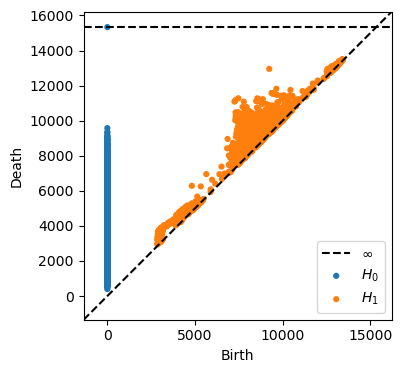

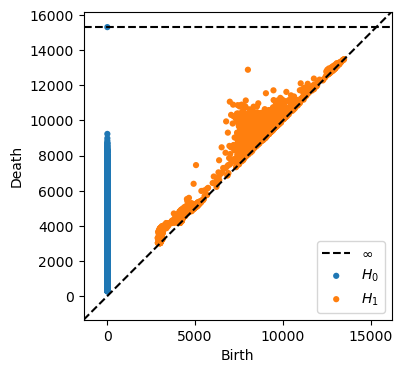

In [24]:
generate_homology(img, (120,120), 60, 5, 2)
generate_homology(img, (120,120), 60, 5, 3)

Lets try some C3 examples

In [26]:
img_names = glob.glob('images/*C3gradient.png')
img = Image.open(img_names[0])
img.show()

In [ ]:
generate_homology(img, (110,110), 60, 5, 2)
generate_homology(img, (110,110), 60, 5, 3)

/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


[6354.939453125, 3389.384033203125, 3101.287109375, 2853.29541015625, 2816.345703125, 2758.94482421875, 2673.3291015625]


/Users/shannagoldman/anaconda3/envs/dreimac/lib/python3.8/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
